In [25]:
%pylab inline

import sys
import os
par_dir = os.path.split(os.getcwd())[0]
if par_dir not in sys.path:
    sys.path.append(par_dir)
# sys.path.append(r'/Users/artemgolovizin/GitHub')
from scipy.optimize import curve_fit
import inspect
import pickle
import imp
import re

from IPython.html import widgets
from IPython.display import display
from IPython.html.widgets import interact, interactive, fixed


from IPython import parallel

import thulium_python_lib.image_processing_new as impr
rc1 = parallel.Client()
lview = rc1.load_balanced_view()
dview = rc1.direct_view()
with dview.sync_imports():
    import sys, os    
dview['par_dir'] = par_dir
%px if par_dir not in sys.path: sys.path.append(par_dir)
#%px if r'/Users/artemgolovizin/GitHub' not in sys.path: sys.path.append(r'/Users/artemgolovizin/GitHub')
%px import thulium_python_lib.image_processing_new as impr
%px import imp
%px from IPython.parallel import bind_kernel; bind_kernel()

Populating the interactive namespace from numpy and matplotlib
importing sys on engine(s)
importing os on engine(s)


`%matplotlib` prevents importing * from pylab and numpy


###Helper functions 

In [26]:
def exp_decay(t, N0, tau, background):
    return N0 * exp(- t / tau) + background
def exp_decay_no_bg(t, N0, tau):
    return N0 * exp(- t / tau)
def cloud_expansion(t, T, r0, t0):
    k_b = 1.38e-23
    m = 169 * 1.66e-27
    return sqrt( r0**2 + 2 * k_b * T * (t + t0)**2 / m)

def tow_body_loss(t, N0, betta, background):
    return 1 / ( betta * t + 1 / N0) + background

def exp_plus_tw_body_decay(t, N0, tau, betta,  background):
    return N0 * exp(- t / tau) / ( 1 + betta * N0 * tau * (1 - exp( -t / tau))) + 0 * background

def two_frac_decay(t, N0, N1, tau, betta,  background):
    return exp_decay(t, N0, tau, 0) + exp_plus_tw_body_decay(t,N1, tau, betta,  0) + abs(background)

def two_frac_decay_no_bg(t, N0, N1, tau, betta, background):
    return two_frac_decay(t, N0, N1, tau, betta,0)

def mod_from_AOM_to_real_freq(data, key, center = 420):
    """Looks for marker 'CL' (clock line) in folder name and does modification"""
    if 'CL' in key.upper(): 
        return (data - center) * 2
    else:
        return data

###Do not foget to cd to the directory you need 

In [35]:
cd 'D:\!Data\2015_07_10'

D:\!Data\2015_07_10


####Create dictionary for tracking key one want to display 

In [36]:
old_ks = dict()

###Interactive display of data from  all_N_atoms_data.txt

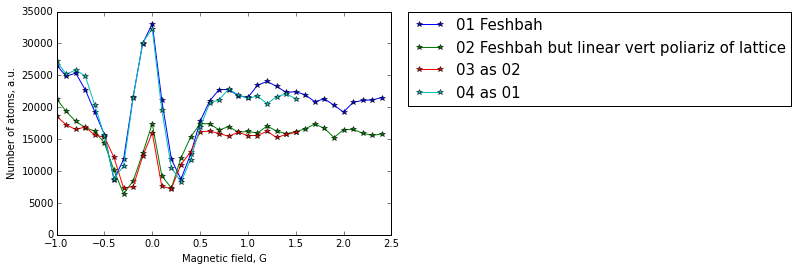

In [40]:
with open('all_N_atoms_data.txt', 'rb') as handle:
    res_dict = pickle.loads(handle.read())

ks = list(res_dict.keys())
ks.sort()
ch_boxes = dict()
ks_n = []
for k in ks:
    # optional - uncomment line below to sift only keys with specific marker, as 'CL'
#    if 'CL' not in k.upper(): continue
    ch_boxes[k]=old_ks.get(k,True)
    ks_n.append(k)
ks = ks_n
fg = None   
def plot_gr(l_pos,**ar):
    fig,ax = subplots() 
    global fg, old_ks
    old_ks = dict()
    for k in ks:
        old_ks[k]=ar[k]
        if ar[k]:
            val=res_dict[k]
            x,y=impr.data2_sort(val[0],val[1])
            # here it's time to modify data
            x = mod_from_AOM_to_real_freq(x, k, 420)
            #x,y = x[1:],y[1:]
            ax.plot(x,y,'-*',label=k)
    legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=15)
    #xscale('log')
    #xlabel('Current, A')
    xlabel('Magnetic field, G')
    #xlabel('AOM frequency, MHz')
    #xlabel('detuning, MHz') #in real frequencyes
    ylabel('Number of atoms, a.u.')
    ylim(bottom=0)
    #start, end = ax.get_xlim()
    #print(ax.get_xlim())
    #ax.xaxis.set_ticks(arange(start, end, 0.1))
    #axvline(x=l_pos)
    fg = fig
    
ter = interactive(plot_gr,l_pos=(150,250,0.1),**ch_boxes)
ter.box_style='info'
display(ter)

###For managing clock line shift and broadening 

In [34]:
c_freq = 419.75 # MHz
working_keys = [x for x in old_ks if old_ks[x]]
print(working_keys)
val1 = []
val2 = []
for key in working_keys:
    # get fit data
    popt = res_dict[key][2]
    for s0 in key.rstrip(r'\/ ').split():
        if '=' in s0:
            s1 = s0.split('=')
            # here one can extract data from folder name of patten 'var=val'
            if s1[0] == 'ampl':
                val1.append((float(s1[1]), popt[1]))
                val2.append((float(s1[1]), popt[2]))
fig3, ax3 = subplots(1,2,figsize=(12,6))
x, y = list(zip(*val1))
y = mod_from_AOM_to_real_freq(array(y), 'CL', c_freq)
ax3[0].plot(x,y,'*r',ms=10)
ax3[0].set_title('shift (center frequency=' + str(c_freq) + 'MHz)')
ax3[0].set_ylabel('shift, MHz')
ax3[0].set_xlabel('power, W')
x, y = list(zip(*val2))
ax3[1].set_title('width')
ax3[1].set_ylabel('width, MHz')
ax3[1].set_xlabel('power, W')
ax3[1].plot(x,y,'*r',ms=10)
#x, y = list(zip(*val))
#plot(x,y,'*')

['15 as 14 with offset', '11 as 10 more detailed', '19 as 18 offset -6 A', '10 3W polarity - and -5A as offset', '07 feshbah 3W as 06', '03 feshbah 6W calibration', '05 feshbah 6W + offset another polarity', '14 6W 3A offset', '12 as 09 further', '13 as 12 6W', '17 as 14 offset=-6A', '01 feshbah 6W', '18 all in another poliarity offset 3A', '04 feshbah 6W +offset', '08 as 07 another polarity +', '06 as 05 no offset', '09 3W polarity - and -3A as offset', '02 feshbah 3W', '16 as 14 offset=-5A']


IndexError: tuple index out of range

In [ ]:
#x1,y1 = res_dict['01 no magnetic field at all']
fig = figure(figsize=(16,10))
xt,yt = res_dict['10 prob in magnetic field 8G']

xt, yt = impr.data2_sort(xt,yt)
#xt, yt = impr.drop_data((xt,yt),(3,))
xt, yt = xt[1:], yt[1:]
plot(xt, yt, 'o-')
fit_func = two_frac_decay_no_bg
popt, pcov = curve_fit(fit_func,xt,yt, p0=(yt[0]/2, yt[0]/2, 500,2e-7,0))
#popt, pcov = curve_fit(fit_func,xt,yt, p0=(yt[0],  500))
print('Fit parameters',*list(zip(inspect.getargspec(fit_func)[0][1:], popt)))
plot(xt,fit_func(xt,*popt))
plot(xt, exp_decay(xt, popt[0], popt[2], popt[-1]))
#plot(xt, exp_plus_tw_body_decay(xt, popt[1], popt[2], popt[3], popt[-1]))

In [ ]:
fit_func
def int_plot(tau, betta):
    plot(xt,yt)
    plot(xt, fit_func(xt, 
interact

###Interactive display of data from all_Temperature_data.txt

###Построение списка сканирования 

In [ ]:
res = array(range(0,35, 1))/100
rr = ''
for x in res:
    rr += str(x) + ' '
print(rr)

###To get some good pictures 
Set up configuration and change it to 'Raw code' when not used